In [100]:
 # Initial imports
import os
import panel as pn
pn.extension('plotly')
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi 
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path
import requests
import urllib.request
import json
import pprint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

In [46]:
 # Load .env enviroment variables
load_dotenv()

True

In [47]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
print(f"ALP Key type:{type(alpaca_secret_key)}")

ALP Key type:<class 'str'>


In [48]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [49]:
# Set start and end dates of five years back from today.

start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-05', tz='America/New_York').isoformat()
timeframe='1D'

In [50]:
# Get historical data for SPY starting in 1/1/2015
tickers = ['SPY']
df_sp500_data = alpaca.get_barset(tickers, timeframe, start = start_date, end = end_date).df
# Display sample data
df_sp500_data.head()

SPY                                    
                             open    high      low   close     volume
2015-01-02 00:00:00-05:00  206.38  206.88  204.180  205.41   94506045
2015-01-05 00:00:00-05:00  204.17  204.37  201.350  201.80  133100354
2015-01-06 00:00:00-05:00  202.09  202.72  198.855  199.82  166955423
2015-01-07 00:00:00-05:00  201.42  202.72  200.880  202.34  103285826
2015-01-08 00:00:00-05:00  204.00  206.16  203.990  205.92  112316394

In [51]:
sp500_df = pd.DataFrame()
sp500_df['open'] = df_sp500_data['SPY']['open']
sp500_df['high'] = df_sp500_data['SPY']['high']
sp500_df['low'] = df_sp500_data['SPY']['low']
sp500_df['close'] = df_sp500_data['SPY']['close']
sp500_df['volume'] = df_sp500_data['SPY']['volume']
sp500_df['date'] = df_sp500_data.index.date
sp500_df.reset_index(inplace=True)
sp500_df = sp500_df[['date','open','high','low','close','volume']]
sp500_df.head()

,date,open,high,low,close,volume
0,2015-01-02,206.38,206.88,204.180,205.41,94506045
1,2015-01-05,204.17,204.37,201.350,201.80,133100354
2,2015-01-06,202.09,202.72,198.855,199.82,166955423
3,2015-01-07,201.42,202.72,200.880,202.34,103285826
4,2015-01-08,204.00,206.16,203.990,205.92,112316394


In [52]:
#Drop columns

sp500_df = sp500_df.drop(['open','high','low','volume'], axis =1)



In [53]:
#Calculate Returns

sp500_df['date']=pd.to_datetime(sp500_df['date'])
sp500_df['close']=sp500_df['close'].pct_change().astype(str).astype('float64')

sp500_df.head()                                

,date,close
0,2015-01-02,NaN
1,2015-01-05,-0.017575
2,2015-01-06,-0.009812
3,2015-01-07,0.012611
4,2015-01-08,0.017693


In [54]:
#df_sp500_data.index=df_sp500_data.index.date
#df_sp500_data.head()

In [55]:
sp500_daily_returns = sp500_df
sp500_daily_returns.head()

,date,close
0,2015-01-02,NaN
1,2015-01-05,-0.017575
2,2015-01-06,-0.009812
3,2015-01-07,0.012611
4,2015-01-08,0.017693


In [56]:
sp500_daily_returns.columns

Index(['date', 'close'], dtype='object')

In [57]:
#Rename columns for later calculation

columns = ['Date', 'Std']
sp500_daily_returns.columns = columns
sp500_daily_returns.head()

,Date,Std
0,2015-01-02,NaN
1,2015-01-05,-0.017575
2,2015-01-06,-0.009812
3,2015-01-07,0.012611
4,2015-01-08,0.017693


In [58]:
#calculate daily standard deviation of the S&P 500
daily_std = sp500_daily_returns.std()
daily_std

Std    0.011728
dtype: float64

In [59]:
#calculate the annualized std(252 trading days)
annualized_std = daily_std*np.sqrt(252)
annualized_std

Std    0.186177
dtype: float64

In [60]:
# Calculate the rolling standard deviation for S&P 500

rolling_std = sp500_daily_returns.rolling(window=21).std()
rolling_std

,Std
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1508,0.005931
1509,0.005792
1510,0.005436
1511,0.006268


In [61]:
# Plot the rolling standard deviation
sp500_rolling_plot = rolling_std.hvplot()
sp500_rolling_plot

:Curve   [index]   (Std)

In [62]:
#call cyrpto quant api and retrieve puell data
load_dotenv()
access_token = os.getenv("COIN_API")
headers = { 'Authorization': 'Bearer ' + access_token }
puell_url= "https://api.cryptoquant.com/v1/btc/network-indicator/puell-multiple?window=day&from=20150101&limit=100000"
response = requests.get(puell_url, headers=headers)

In [63]:
response


<Response [200]>

In [64]:
def get_btc_price():

    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
    response_btc = requests.get(BTC_price_data, headers=headers)

    price_data_raw = response_btc.json()

    BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
    BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
    BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    
    BTC_price_df = BTC_price_df.dropna()
    
    return BTC_price_df

In [65]:
#Create puell mulitple data frame by calling crypto quant API

puell_data = response.json()

puell_df = pd.DataFrame(data=puell_data['result']['data'])
puell_df['date']=pd.to_datetime(puell_df['date'])
#puell_df=puell_df.set_index('date')
#puell_df = puell_df.pct_change()

In [66]:
#create function
def get_puell_multiple_data():
    
    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    puell_url= "https://api.cryptoquant.com/v1/btc/network-indicator/puell-multiple?window=day&from=20150101&limit=100000"
    response = requests.get(puell_url, headers=headers)
    puell_data = response.json()

    puell_df = pd.DataFrame(data=puell_data['result']['data'])
    puell_df['date']=pd.to_datetime(puell_df['date'])
    
    return puell_df

In [67]:
#Sort data

puell_plot = puell_df.hvplot(x='date',y='puell_multiple',sort_date = True)


In [68]:
#Plot Puell Mulitple

puell_plot = puell_df.hvplot()
puell_plot

:Curve   [index]   (puell_multiple)

In [69]:
    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }

In [70]:
   #Retreive BTC closing prices
    
BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
response_btc = requests.get(BTC_price_data, headers=headers)

price_data_raw = response_btc.json()

BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    #BTC_price_df = BTC_price_df.dropna()
    #BTC_price_df = BTC_price_df.set_index('date')
    #BTC_daily_returns_df = BTC_price_df.pct_change()

    

In [71]:
#sort data
btc_plot = BTC_price_df.hvplot(x='date',y='price_usd_close',sort_date = True)

In [72]:
btc_plot

:Curve   [date]   (price_usd_close)

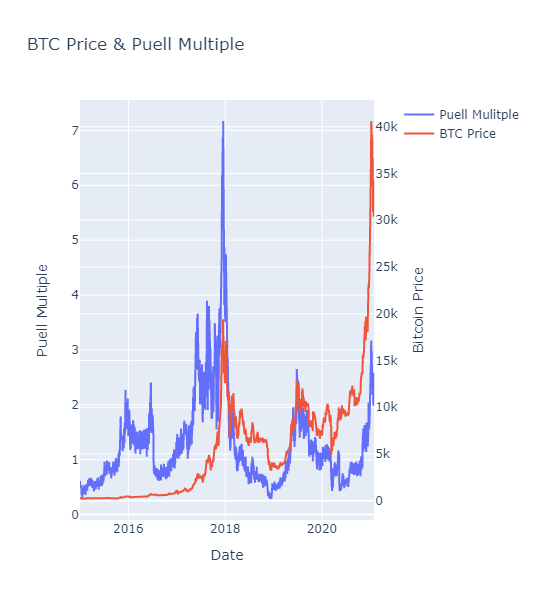

In [101]:
#Create dual Y axis plot to visualize puell multiple along with btc price

fig3 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig3.add_trace(
    go.Scatter(mode = 'lines',x=puell_df['date'],y=puell_df['puell_multiple'], name = 'Puell Mulitple'),
    secondary_y=False 
)

fig3.add_trace(
    go.Scatter(mode = 'lines',x=BTC_price_df['date'], y =BTC_price_df ['price_usd_close'], name = 'BTC Price'),
    secondary_y=True 
)

fig3.update_layout(
    height = 600,width = 1500,
    title_text = 'BTC Price & Puell Multiple'
)

fig3.update_xaxes(title_text = 'Date')

fig3.update_yaxes(title_text='Puell Multiple', secondary_y= False)
fig3.update_yaxes(title_text='Bitcoin Price', secondary_y= True)



fig3.show()

In [74]:
def get_btc_price():

    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
    response_btc = requests.get(BTC_price_data, headers=headers)

    price_data_raw = response_btc.json()

    BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
    BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
    BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    
    BTC_price_df = BTC_price_df.dropna()
    
    return BTC_price_df

In [75]:
BTC_price_df.head()

,date,price_usd_close
0,2021-01-30,34286.360000
1,2021-01-29,34244.506667
2,2021-01-28,33383.746667
3,2021-01-27,30385.111667
4,2021-01-26,32489.385000


In [76]:
#BTC_price_df = BTC_price_df.set_index('date')
#BTC_price_df

In [77]:
BTC_price_df['date']=pd.to_datetime(BTC_price_df['date'])
BTC_price_df['price_usd_close']=BTC_price_df['price_usd_close'].pct_change().astype(str).astype('float64')

BTC_price_df.head()    

,date,price_usd_close
0,2021-01-30,NaN
1,2021-01-29,-0.001221
2,2021-01-28,-0.025136
3,2021-01-27,-0.089823
4,2021-01-26,0.069253


In [78]:
btc_daily_returns=BTC_price_df
btc_daily_returns.head()

,date,price_usd_close
0,2021-01-30,NaN
1,2021-01-29,-0.001221
2,2021-01-28,-0.025136
3,2021-01-27,-0.089823
4,2021-01-26,0.069253


In [79]:
btc_daily_returns.columns

Index(['date', 'price_usd_close'], dtype='object')

In [80]:
columns=['Date','Std']
btc_daily_returns.columns = columns
btc_daily_returns.head()

,Date,Std
0,2021-01-30,NaN
1,2021-01-29,-0.001221
2,2021-01-28,-0.025136
3,2021-01-27,-0.089823
4,2021-01-26,0.069253


In [81]:
btc_rolling_std = btc_daily_returns.rolling(window=21).std()


In [82]:
btc_rolling_plot = btc_daily_returns.hvplot.scatter(x='Date',y='Std',sort_date = True)

In [83]:
#btc_cumulative_r_plot = btc_cumulative_returns.hvplot(x='date',y='price_usd_close',sort_date = True)

In [84]:
btc_rolling_plot

:Scatter   [Date]   (Std)

In [85]:
btc_daily_std = btc_daily_returns.std()
btc_daily_std

Std    0.040944
dtype: float64

In [86]:
btc_annual_std = btc_daily_std*np.sqrt(252)
btc_annual_std

Std    0.649974
dtype: float64

In [87]:
#btc_rolling_std = btc_daily_returns.rolling(window=21).std()
#btc_rolling_std

In [88]:
#btc_plot = BTC_price_df.hvplot(x='date',y='price_usd_close',sort_date = True)

In [89]:
btc_rolling_plot = btc_rolling_std.hvplot(x='Date',y='Std',sort_date=True)

In [90]:
btc_rolling_plot

:Curve   [Date]   (Std)

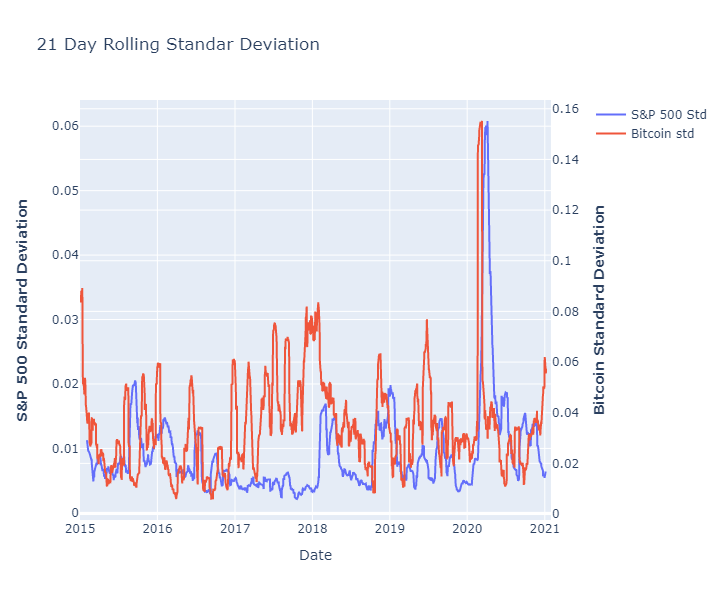

In [91]:
fig4 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig4.add_trace(
    go.Scatter(mode = 'lines',x=sp500_daily_returns['Date'],y=rolling_std['Std'], name = 'S&P 500 Std'),
    secondary_y=False 
)

fig4.add_trace(
    go.Scatter(mode = 'lines',x=btc_daily_returns['Date'], y =btc_rolling_std ['Std'], name = 'Bitcoin std'),
    secondary_y=True 
)

fig4.update_layout(
    height = 600,width = 1100,
    title_text = '21 Day Rolling Standar Deviation'
)

fig4.update_xaxes(title_text = 'Date')

fig4.update_yaxes(title_text='<b>S&P<b> 500 Standard Deviation', secondary_y= False)
fig4.update_yaxes(title_text='<b>Bitcoin<b> Standard Deviation', secondary_y= True)



fig4.show()
